**NAME: SOUHARDO RAHMAN**

**ID: 22-59068-3**

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(27)

X shape: (1500, 2)
y shape: (1500,)
Unique classes: [0 1 2 3 4]


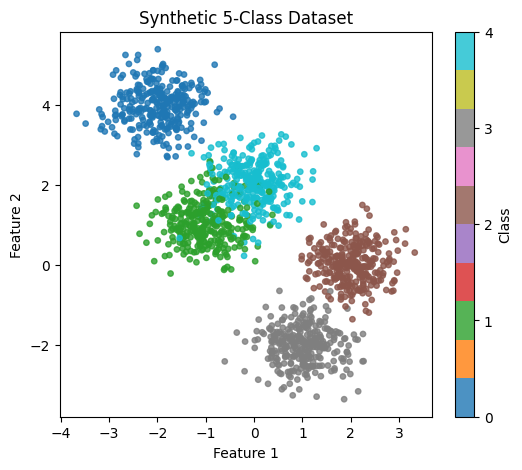

In [15]:
num_classes = 5
points_per_class = 300

# Defining 5 cluster centers
centers = np.array([
    [-2.0,  4.0],
    [ -1.0,  1.0],
    [ 2.0,  0.0],
    [ 1.0, -2.0],
    [ 0.0,  2.0],
])

X_list = []
y_list = []

for class_id in range(num_classes):
    X_c = np.random.randn(points_per_class, 2) * 0.5 + centers[class_id]
    y_c = np.full(points_per_class, class_id, dtype=int)
    X_list.append(X_c)
    y_list.append(y_c)

X = np.vstack(X_list)   # shape (N, 2)
y = np.hstack(y_list)   # shape (N,)

# Shuffle data
indices = np.random.permutation(len(X))
X = X[indices]
y = y[indices]

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique classes:", np.unique(y))

# Visualize
plt.figure(figsize=(6, 5))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap="tab10", s=15, alpha=0.8)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Synthetic 5-Class Dataset")
plt.colorbar(scatter, ticks=range(num_classes), label="Class")
plt.show()


In [16]:
def train_test_split(X, y, test_ratio=0.2):
    N = len(X)
    split_idx = int(N * (1 - test_ratio))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_ratio=0.2)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

# Standardize features using training statistics
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-8

X_train_norm = (X_train - X_mean) / X_std
X_test_norm = (X_test - X_mean) / X_std

def to_one_hot(y, num_classes):
    N = y.shape[0]
    one_hot = np.zeros((N, num_classes))
    one_hot[np.arange(N), y] = 1
    return one_hot

Y_train_one_hot = to_one_hot(y_train, num_classes)

print("One-hot label shape:", Y_train_one_hot.shape)


Train size: 1200
Test size: 300
One-hot label shape: (1200, 5)


In [17]:
class NeuralNetworkMultiClass:
    def __init__(self, input_dim, h1, h2, h3, num_classes, learning_rate=0.01, seed=0):
        rng = np.random.default_rng(seed)
        self.learning_rate = learning_rate

        # random initialization
        self.W1 = rng.normal(0, 1.0 / np.sqrt(input_dim), size=(input_dim, h1))
        self.b1 = np.zeros((1, h1))

        self.W2 = rng.normal(0, 1.0 / np.sqrt(h1), size=(h1, h2))
        self.b2 = np.zeros((1, h2))

        self.W3 = rng.normal(0, 1.0 / np.sqrt(h2), size=(h2, h3))
        self.b3 = np.zeros((1, h3))

        self.W4 = rng.normal(0, 1.0 / np.sqrt(h3), size=(h3, num_classes))
        self.b4 = np.zeros((1, num_classes))

    # Activation
    def relu(self, z):
        return np.maximum(0, z)

    def relu_deriv(self, z):
        return (z > 0).astype(float)

    def softmax(self, z):
        z_shifted = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_shifted)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    # Forward
    def feedForward(self, X):
        self.X = X

        self.Z1 = X @ self.W1 + self.b1
        self.A1 = self.relu(self.Z1)

        self.Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = self.relu(self.Z2)

        self.Z3 = self.A2 @ self.W3 + self.b3
        self.A3 = self.relu(self.Z3)

        self.Z4 = self.A3 @ self.W4 + self.b4
        self.A4 = self.softmax(self.Z4)

        return self.A4

    # Loss
    def compute_loss(self, Y_true_one_hot, Y_pred_probs):
        eps = 1e-9
        N = Y_true_one_hot.shape[0]
        log_probs = -np.log(Y_pred_probs + eps)
        loss = np.sum(Y_true_one_hot * log_probs) / N
        return loss

    # Backpropagation
    def backPropagation(self, Y_true_one_hot, Y_pred_probs):
        N = Y_true_one_hot.shape[0]
        lr = self.learning_rate

        # Gradient at output layer
        dZ4 = (Y_pred_probs - Y_true_one_hot) / N
        dW4 = self.A3.T @ dZ4
        db4 = np.sum(dZ4, axis=0, keepdims=True)

        # Backprop into Hidden 3
        dA3 = dZ4 @ self.W4.T
        dZ3 = dA3 * self.relu_deriv(self.Z3)
        dW3 = self.A2.T @ dZ3
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        # Backprop into Hidden 2
        dA2 = dZ3 @ self.W3.T
        dZ2 = dA2 * self.relu_deriv(self.Z2)
        dW2 = self.A1.T @ dZ2
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        # Backprop into Hidden 1
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * self.relu_deriv(self.Z1)
        dW1 = self.X.T @ dZ1
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        # Parameter updates (gradient descent)
        self.W4 -= lr * dW4
        self.b4 -= lr * db4

        self.W3 -= lr * dW3
        self.b3 -= lr * db3

        self.W2 -= lr * dW2
        self.b2 -= lr * db2

        self.W1 -= lr * dW1
        self.b1 -= lr * db1

    # Prediction
    def predict(self, X):
        probs = self.feedForward(X)
        preds = np.argmax(probs, axis=1)
        return preds, probs


In [18]:
input_dim = X_train_norm.shape[1]
h1, h2, h3 = 15, 15, 10            # hidden layer sizes
learning_rate = 0.05
epochs = 1000

nn = NeuralNetworkMultiClass(
    input_dim=input_dim,
    h1=h1,
    h2=h2,
    h3=h3,
    num_classes=num_classes,
    learning_rate=learning_rate,
    seed=42
)

train_losses = []
train_accuracies = []

for epoch in range(epochs):
    # Forward pass
    probs = nn.feedForward(X_train_norm)

    # Compute loss
    loss = nn.compute_loss(Y_train_one_hot, probs)
    train_losses.append(loss)

    # Compute training accuracy
    train_preds = np.argmax(probs, axis=1)
    train_acc = np.mean(train_preds == y_train)
    train_accuracies.append(train_acc)

    # Backprop + update
    nn.backPropagation(Y_train_one_hot, probs)

    # Print progress occasionally
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f} - Train Acc: {train_acc:.4f}")


Epoch 100/1000 - Loss: 0.6788 - Train Acc: 0.7208
Epoch 200/1000 - Loss: 0.3940 - Train Acc: 0.9058
Epoch 300/1000 - Loss: 0.2282 - Train Acc: 0.9467
Epoch 400/1000 - Loss: 0.1518 - Train Acc: 0.9517
Epoch 500/1000 - Loss: 0.1263 - Train Acc: 0.9542
Epoch 600/1000 - Loss: 0.1154 - Train Acc: 0.9567
Epoch 700/1000 - Loss: 0.1095 - Train Acc: 0.9567
Epoch 800/1000 - Loss: 0.1058 - Train Acc: 0.9583
Epoch 900/1000 - Loss: 0.1032 - Train Acc: 0.9583
Epoch 1000/1000 - Loss: 0.1012 - Train Acc: 0.9600


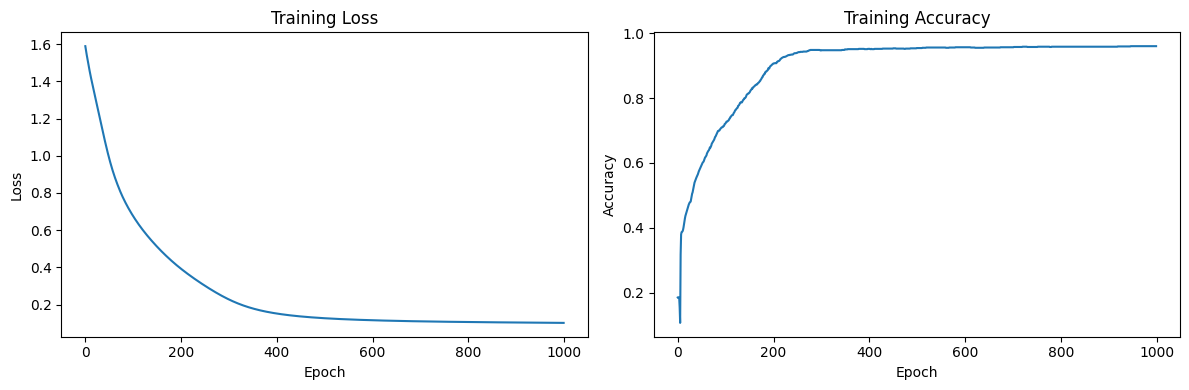

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
axs[0].plot(train_losses)
axs[0].set_title("Training Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")

# Accuracy plot
axs[1].plot(train_accuracies)
axs[1].set_title("Training Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

Test accuracy: 0.9533

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      1.00      0.99        55
     Class 1       0.89      0.93      0.91        68
     Class 2       1.00      1.00      1.00        64
     Class 3       1.00      1.00      1.00        49
     Class 4       0.92      0.86      0.89        64

    accuracy                           0.95       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.95      0.95      0.95       300

Confusion Matrix:
 [[55  0  0  0  0]
 [ 0 63  0  0  5]
 [ 0  0 64  0  0]
 [ 0  0  0 49  0]
 [ 1  8  0  0 55]]


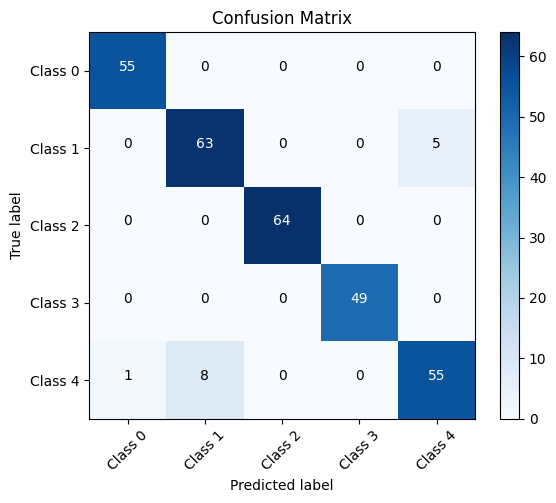

In [20]:
# Predict on test data
y_test_pred, test_probs = nn.predict(X_test_norm)

test_accuracy = np.mean(y_test_pred == y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Classification report
class_names = [f"Class {i}" for i in range(num_classes)]
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.0
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(
            j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


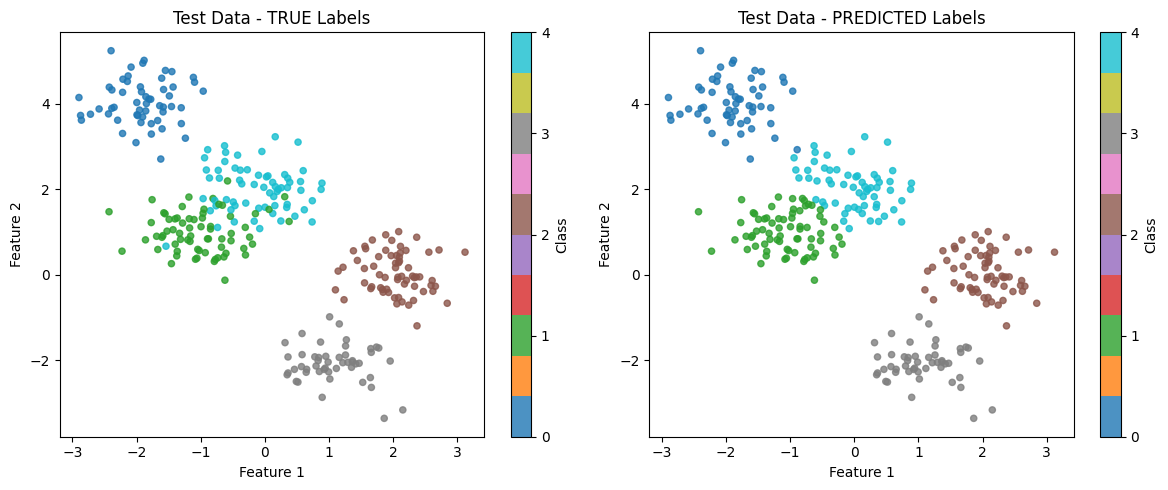

In [21]:
plt.figure(figsize=(12, 5))

# True labels
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="tab10", s=20, alpha=0.8)
plt.title("Test Data - TRUE Labels")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(scatter1, ticks=range(num_classes), label="Class")

# Predicted labels
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test_pred, cmap="tab10", s=20, alpha=0.8)
plt.title("Test Data - PREDICTED Labels")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(scatter2, ticks=range(num_classes), label="Class")

plt.tight_layout()
plt.show()


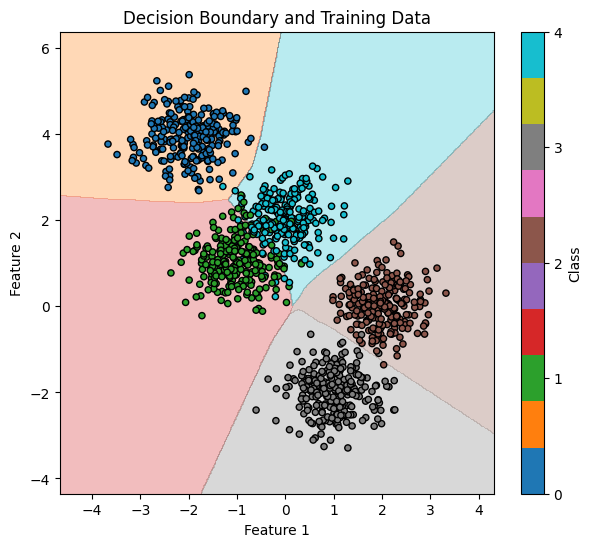

In [22]:
# Define grid over feature space
x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0
h = 0.02  # step size in the mesh

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

grid_points = np.c_[xx.ravel(), yy.ravel()]            # shape (M, 2)
grid_points_norm = (grid_points - X_mean) / X_std      # normalize like training data

Z, _ = nn.predict(grid_points_norm)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(7, 6))

# Plot decision regions
plt.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(num_classes + 1) - 0.5, cmap="tab10")

# Plot training points
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="tab10", edgecolor="k", s=20)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Decision Boundary and Training Data")
plt.colorbar(scatter, ticks=range(num_classes), label="Class")

plt.show()


Custom test points classification:
Input [-4 -1] -> Predicted Class 1
Input [-4  4] -> Predicted Class 0
Input [0 0] -> Predicted Class 1
Input [ 2 -4] -> Predicted Class 3
Input [4 1] -> Predicted Class 2
Input [0 3] -> Predicted Class 4


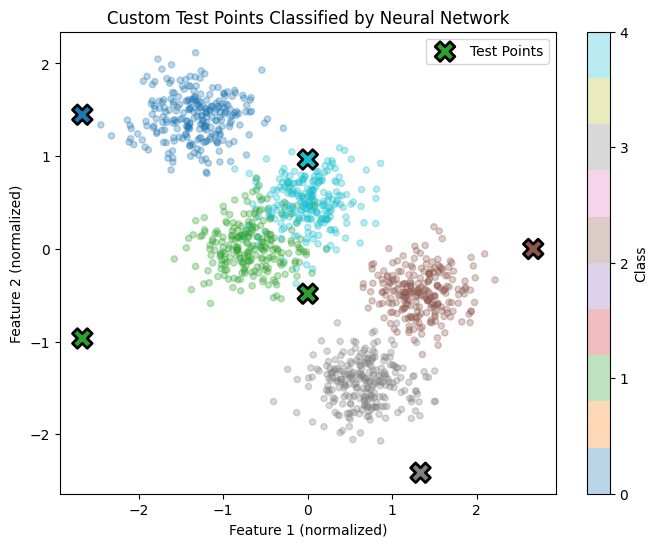

In [28]:
# Custom test points
test_points = np.array([
    [-4, -1],
    [-4, 4],
    [0, 0],
    [2, -4],
    [4, 1],
    [0, 3]
])

# Normalize
test_points_norm = (test_points - X_mean) / X_std

# Predict classes
pred_for_points, _ = nn.predict(test_points_norm)

print("Custom test points classification:")
for pt, pc in zip(test_points, pred_for_points):
    print(f"Input {pt} -> Predicted Class {pc}")

# Visualization
plt.figure(figsize=(8, 6))

scatter = plt.scatter(X_train_norm[:, 0], X_train_norm[:, 1], c=y_train,
                      cmap="tab10", alpha=0.3, s=20, vmin=0, vmax=num_classes-1)

# Plot custom test points
plt.scatter(test_points_norm[:, 0], test_points_norm[:, 1], c=pred_for_points,
            cmap="tab10", marker='X', s=200, edgecolors='black', linewidths=2,
            label='Test Points', vmin=0, vmax=num_classes-1)

plt.title("Custom Test Points Classified by Neural Network")
plt.xlabel("Feature 1 (normalized)")
plt.ylabel("Feature 2 (normalized)")

cbar = plt.colorbar(scatter, ticks=range(num_classes))
cbar.set_label("Class")

plt.legend(loc='upper right')
plt.show()

In this assignment, we implemented a deep neural network from scratch using NumPy to solve a multi-class classification problem. The primary objective was to extend a basic neural network architecture to include three hidden layers and handle five distinct classes. The implementation involves custom forward and backward propagation algorithms without the use of high-level frameworks like TensorFlow or PyTorch.



---


## **Dataset Generation**

To train the model, we generated a synthetic dataset.

Generation: Defined 5 manual center coordinates and generated Gaussian noise around them. This creates a challenging yet structured dataset.

### *Preprocessing:*

**Splitting**: The data was shuffled and split into 80% Training and 20% Testing sets.

**Normalization**: We applied Z-Score Standardization using statistics from the training set to ensure the neural network converges efficiently.

**Encoding**: Target labels were converted to One-Hot Vectors to match the output layer format.
<br><br>


---


## **Architecture & Code Modifications**

The neural network class was significantly modified to support multi-class classification:
<br><br>
### *Network Structure*

Input Layer: 2 Features

Hidden Layers: 3 Layers (using ReLU activation)

Output Layer: 5 Neurons

Activation Functions

Hidden Layers: Used ReLU (Rectified Linear Unit) to prevent vanishing gradients in the deeper network.

Output Layer: Implemented Softmax activation to output a probability distribution across the 5 classes.
<br><br>


---


### *Optimization Techniques*

Loss Function: Replaced binary loss with Categorical Cross-Entropy Loss to correctly punish misclassifications in a multi-class setting.

Initialization: Implemented He Initialization (scaling weights by $\sqrt{2/n}$) to ensure stability when using ReLU activations.
<br><br>


---


## **Training and Testing**

Training Configuration: The model was trained for 1500 epochs with a learning rate of 0.1.

Optimization: We used standard Batch Gradient Descent. In every epoch, the model computed the gradients for all layers using the chain rule (Backpropagation) and updated the weights and biases.
<br><br>


---


## **Results and Analysis**

Achieved accuracy of 95% with minor misclassifications. The code outputs three key visualizations to analyze performance:

**Loss Curve**: Shows the Categorical Cross-Entropy decreasing over epochs, indicating the network is successfully learning.

**Confusion Matrix**: A heatmap displaying the correspondence between True and Predicted classes. Diagonal elements represent correct predictions, allowing us to see which classes are most easily confused.

**Decision Boundar**y: A contour plot visualizing the regions of the 2D feature space assigned to each class. This confirms the network has learned non-linear boundaries to separate the clusters.
<br><br>


---


## **Conclusion**

The implementation successfully demonstrates that a 3-hidden layer neural network can solve non-linear multi-class classification tasks. Key insights include the importance of Standardization for convergence and He Initialization for training deep networks with ReLU. The final decision boundaries effectively separate the five classes with high accuracy.